In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler)
from sklearn.metrics import (accuracy_score,
                            mean_absolute_error,
                            mean_absolute_percentage_error,
                            precision_score,
                            recall_score,
                            f1_score,
                            root_mean_squared_error,
                            r2_score)
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression,
                                  Ridge)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC

In [19]:
# df = pd.read_parquet("/content/drive/MyDrive/datasets/reddit_parser_2024_12_06_prices.parquet")
df = pd.read_parquet("/Users/grylkov/git/hse/analytics-platform/parsers/reddit/reddit_parser_2024_12_06_prices.parquet")

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8416 entries, 0 to 8415
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     8416 non-null   object        
 1   title                  847 non-null    object        
 2   url                    847 non-null    object        
 3   subreddit              8416 non-null   object        
 4   created_utc            8416 non-null   datetime64[ns]
 5   parsed_utc             8416 non-null   object        
 6   text                   8416 non-null   object        
 7   score                  8416 non-null   int64         
 8   num_comments           847 non-null    float64       
 9   type                   8416 non-null   object        
 10  parent_id              7569 non-null   object        
 11  clean_text             8416 non-null   object        
 12  processed_text         8416 non-null   object        
 13  pro

In [21]:
df.head()

,id,title,url,subreddit,created_utc,parsed_utc,text,score,num_comments,type,...,clean_text,processed_text,processed_text_length,sentiment_scores,entities,doc_embedding,tickers,ticker,created_price,price_1d
0,m0miqte,None,None,investing,2024-12-05 23:58:30,2024-12-06 17:55:40,Depends on what type of debt. For example if i...,3,NaN,comment,...,depends type debt. for example it’s debt mortg...,depend type debt for exampl it debt mortgag at...,594,-0.0772,"[PATH, FDIS, RPA, BTI, AMEX, Robotic Process A...","[1.0175916, -0.26974982, -0.18348941, -0.53738...","[PATH, BTI]",PATH,14.940000,14.820000
1,m0lmgzo,None,None,investing,2024-12-05 21:00:41,2024-12-06 17:55:40,KAR and PRAA,1,NaN,comment,...,kar praa,kar praa,12,0.0000,[KAR],"[0.0036067592, -0.009290272, -0.0037351453, -0...",[KAR],KAR,20.250000,20.190001
2,m0lvb3h,None,None,investing,2024-12-05 21:46:35,2024-12-06 17:55:41,"36 years old, married but no kids yet. Have 90...",4,NaN,comment,...,"36 years old, married kids yet. have 90% equit...",year old marri kid yet have equiti short term ...,433,-0.6652,"[ETH, VGT, QQQ, VOO]","[0.24014705, -0.79617554, -0.21952175, 0.06111...","[ETH, QQQ]",QQQ,521.799988,526.510010
3,1h7i31g,My biggest fear for 2025 is declines becoming ...,https://www.reddit.com/r/investing/comments/1h...,investing,2024-12-05 19:53:10,2024-12-06 17:55:42,"When has this not been a risk, it's why the ec...",102,92.0,submission,...,"when risk, economy acts ratchet, going slow fa...",when risk economi act ratchet go slow fast but...,1362,-0.9131,"[Economics, fed, AI]","[0.36487904, -0.9539981, -0.13656119, -1.58051...",[AI],AI,37.490002,40.520000
4,m0m473e,None,None,investing,2024-12-05 22:33:54,2024-12-06 17:55:42,I'm waiting for Tesla to pop. From there I spe...,1,NaN,comment,...,i'm waiting tesla pop. from i speculate automa...,i wait tesla pop from i specul automak tech bu...,332,-0.1280,"[Tesla, AI]","[0.4363078, -0.67959464, 0.8144916, 0.16138163...",[AI],AI,37.490002,40.520000


# Data cleaning

### Drop redundant columns

In [22]:
df.drop(columns=['id', 'title', 'url', 'created_utc', 'parsed_utc', 'text', 'parent_id', 'clean_text', 'processed_text', 'entities', 'tickers'], inplace=True)

In [23]:
df.head()

,subreddit,score,num_comments,type,processed_text_length,sentiment_scores,doc_embedding,ticker,created_price,price_1d
0,investing,3,NaN,comment,594,-0.0772,"[1.0175916, -0.26974982, -0.18348941, -0.53738...",PATH,14.940000,14.820000
1,investing,1,NaN,comment,12,0.0000,"[0.0036067592, -0.009290272, -0.0037351453, -0...",KAR,20.250000,20.190001
2,investing,4,NaN,comment,433,-0.6652,"[0.24014705, -0.79617554, -0.21952175, 0.06111...",QQQ,521.799988,526.510010
3,investing,102,92.0,submission,1362,-0.9131,"[0.36487904, -0.9539981, -0.13656119, -1.58051...",AI,37.490002,40.520000
4,investing,1,NaN,comment,332,-0.1280,"[0.4363078, -0.67959464, 0.8144916, 0.16138163...",AI,37.490002,40.520000


In [24]:
df['ticker'].value_counts()

ticker
NVDA    757
MSTR    756
ACHR    650
AI      588
SPY     501
       ... 
EVTL      1
IAUM      1
HALO      1
UUUU      1
JFIN      1
Name: count, Length: 810, dtype: int64

### Fill missing values

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8416 entries, 0 to 8415
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   subreddit              8416 non-null   object 
 1   score                  8416 non-null   int64  
 2   num_comments           847 non-null    float64
 3   type                   8416 non-null   object 
 4   processed_text_length  8416 non-null   int64  
 5   sentiment_scores       8416 non-null   float64
 6   doc_embedding          8416 non-null   object 
 7   ticker                 8416 non-null   object 
 8   created_price          8416 non-null   float64
 9   price_1d               8416 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 657.6+ KB


In [26]:
df['num_comments'] = df['num_comments'].fillna(0)

# Regression

### Use embedding mean for linear regression

In [ ]:
df_em = df.copy()
df_em['embedding_mean'] = df['doc_embedding'].apply(lambda x: np.mean(x))
df_em.drop(columns=['doc_embedding'], inplace=True)

<Axes: >

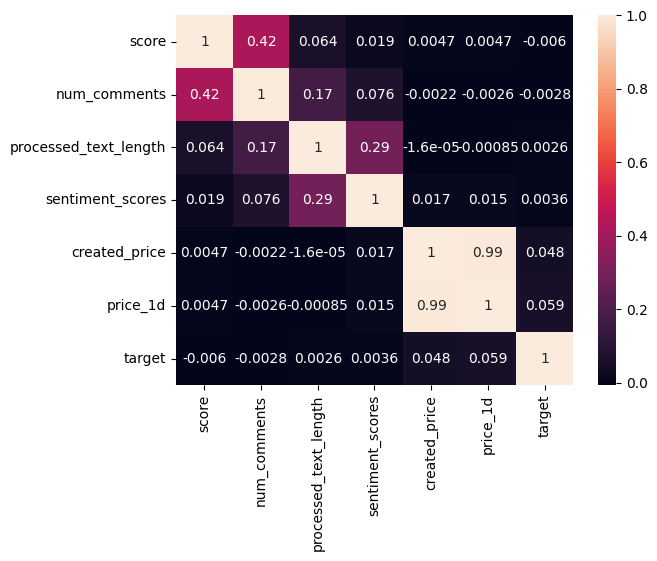

In [ ]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

### Calculate regression target as price change percentage and remove outliers

In [ ]:
df_em['target'] = ((df_em['price_1d'] - df_em['created_price'])/df_em['created_price']) * 100

In [ ]:
df_em = df_em[df_em['target'] > -100]
df_em = df_em[df_em['target'] < 100]

array([[<Axes: title={'center': 'target'}>]], dtype=object)

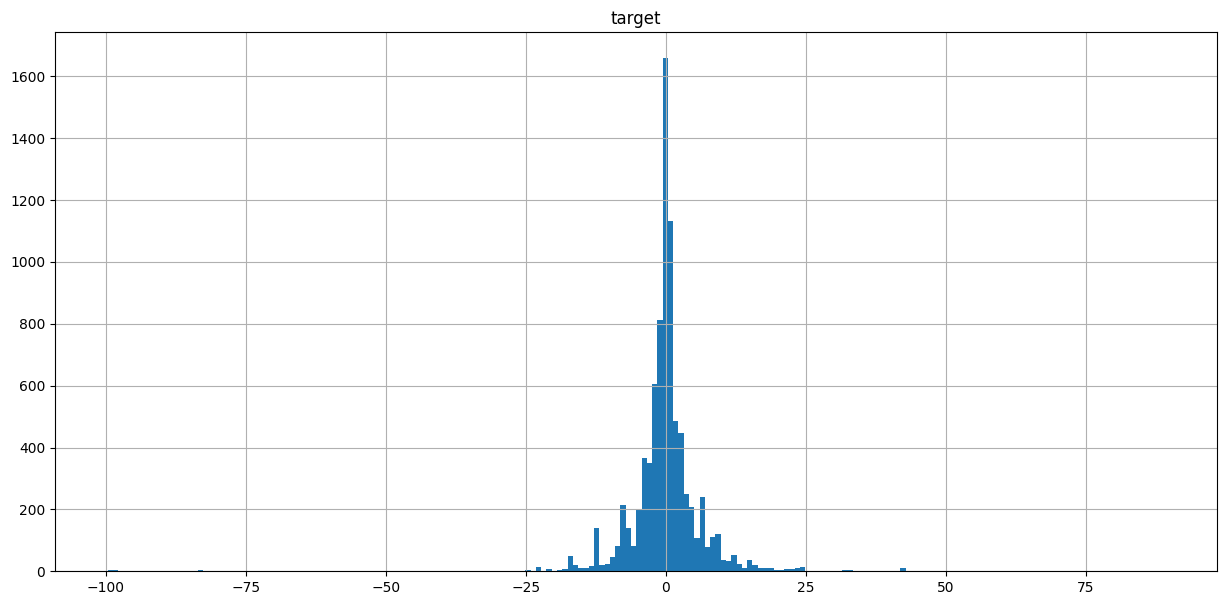

In [ ]:
df_em.hist('target', bins=200, figsize=(15, 7))

## Regression baseline

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_em.drop(columns=['target', 'price_1d']), df_em['target'], test_size=0.2, random_state=69)
X_train['baseline'] = y_train.median()

In [ ]:
X_test['baseline'] = y_train.median()

RMSE = root_mean_squared_error(y_test, X_test['baseline'])
R2 = r2_score(y_test, X_test['baseline'])
MAE = mean_absolute_error(y_test, X_test['baseline'])
MAPE = mean_absolute_percentage_error(y_test, X_test['baseline'])

print(f"RMSE baseline: {RMSE}")
print(f"R2 baseline: {R2}")
print(f"MAE baseline: {MAE}")
print(f"MAPE baseline: {MAPE}")

RMSE baseline: 8.74043427063015
R2 baseline: -0.0001449942765967549
MAE baseline: 4.0811469425353355
MAPE baseline: 313308683953.5865


## Experiment 1: LR, OHE tickers

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_em.drop(columns=['target', 'price_1d']), df_em['target'], test_size=0.2, random_state=69)

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

X_train_encoded = ohe.fit_transform(X_train[['subreddit', 'type', 'ticker']])

X_train_encoded = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names_out(), index=X_train.index)

In [ ]:
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_train.drop(columns=['subreddit', 'type', 'ticker'], inplace=True)
X_train.shape

(6726, 718)

In [ ]:
X_test_encoded = ohe.transform(X_test[['subreddit', 'type', 'ticker']])

X_test_encoded = pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names_out(), index=X_test.index)

X_test = pd.concat([X_test, X_test_encoded], axis=1)
X_test.drop(columns=['subreddit', 'type', 'ticker'], inplace=True)

X_test.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(1682, 718)

In [ ]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=ss.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=ss.get_feature_names_out(), index=X_test.index)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

RMSE_train = root_mean_squared_error(y_train, pred_train)
R2_train = r2_score(y_train, pred_train)
MAE_train = mean_absolute_error(y_train, pred_train)
MAPE_train = mean_absolute_percentage_error(y_train, pred_train)

RMSE_test = root_mean_squared_error(y_test, pred_test)
R2_test = r2_score(y_test, pred_test)
MAE_test = mean_absolute_error(y_test, pred_test)
MAPE_test = mean_absolute_percentage_error(y_test, pred_test)

print(f"RMSE_train: {RMSE_train}")
print(f"R2_train: {R2_train}")
print(f"MAE_train: {MAE_train}")
print(f"MAPE_train: {MAPE_train}")
print("-------------------------")
print(f"RMSE_test: {RMSE_test}")
print(f"R2_test: {R2_test}")
print(f"MAE_test: {MAE_test}")
print(f"MAPE_test: {MAPE_test}")

RMSE_train: 6.2255653503348345
R2_train: 0.30025619829290273
MAE_train: 3.3404977361584423
MAPE_train: 4417711597652.801
-------------------------
RMSE_test: 8.048546026214133
R2_test: 0.1519297918769299
MAE_test: 4.262733521618125
MAPE_test: 5973959166614.119


## Experiment 2: LR, drop tickers

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_em.drop(columns=['target', 'price_1d']), df_em['target'], test_size=0.2, random_state=69)

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

X_train_encoded = ohe.fit_transform(X_train[['subreddit', 'type']])

X_train_encoded = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names_out(), index=X_train.index)

In [ ]:
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_train.drop(columns=['subreddit', 'type', 'ticker'], inplace=True)
X_train.shape

(6726, 13)

In [ ]:
X_test_encoded = ohe.transform(X_test[['subreddit', 'type']])

X_test_encoded = pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names_out(), index=X_test.index)

X_test = pd.concat([X_test, X_test_encoded], axis=1)
X_test.drop(columns=['subreddit', 'type', 'ticker'], inplace=True)

X_test.shape

(1682, 13)

In [ ]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=ss.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=ss.get_feature_names_out(), index=X_test.index)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

RMSE_train = root_mean_squared_error(y_train, pred_train)
R2_train = r2_score(y_train, pred_train)
MAE_train = mean_absolute_error(y_train, pred_train)
MAPE_train = mean_absolute_percentage_error(y_train, pred_train)

RMSE_test = root_mean_squared_error(y_test, pred_test)
R2_test = r2_score(y_test, pred_test)
MAE_test = mean_absolute_error(y_test, pred_test)
MAPE_test = mean_absolute_percentage_error(y_test, pred_test)

print(f"RMSE_train: {RMSE_train}")
print(f"R2_train: {R2_train}")
print(f"MAE_train: {MAE_train}")
print(f"MAPE_train: {MAPE_train}")
print("-------------------------")
print(f"RMSE_test: {RMSE_test}")
print(f"R2_test: {R2_test}")
print(f"MAE_test: {MAE_test}")
print(f"MAPE_test: {MAPE_test}")

RMSE_train: 7.423334354553378
R2_train: 0.005099814831342364
MAE_train: 3.8305584769836445
MAPE_train: 5463511917987.38
-------------------------
RMSE_test: 8.714644180500525
R2_test: 0.005748482930035603
MAE_test: 4.1777863336987915
MAPE_test: 2290938515847.97


## Experiment 3: Ridge, OHE tickers

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_em.drop(columns=['target', 'price_1d']), df_em['target'], test_size=0.2, random_state=69)

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

X_train_encoded = ohe.fit_transform(X_train[['subreddit', 'type', 'ticker']])

X_train_encoded = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names_out(), index=X_train.index)

In [ ]:
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_train.drop(columns=['subreddit', 'type', 'ticker'], inplace=True)
X_train.shape

(6726, 718)

In [ ]:
X_test_encoded = ohe.transform(X_test[['subreddit', 'type', 'ticker']])

X_test_encoded = pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names_out(), index=X_test.index)

X_test = pd.concat([X_test, X_test_encoded], axis=1)
X_test.drop(columns=['subreddit', 'type', 'ticker'], inplace=True)

X_test.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(1682, 718)

In [ ]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=ss.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=ss.get_feature_names_out(), index=X_test.index)

In [ ]:

ridge = Ridge()

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

gs = GridSearchCV(ridge, param_grid, n_jobs=-1, cv=10, scoring='r2')
gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000,
                                   100000, 1000000]},
             scoring='r2')

In [ ]:
best_grid = gs.best_estimator_

pred_train = best_grid.predict(X_train)
pred_test = best_grid.predict(X_test)

RMSE_train = root_mean_squared_error(y_train, pred_train)
R2_train = r2_score(y_train, pred_train)
MAE_train = mean_absolute_error(y_train, pred_train)
MAPE_train = mean_absolute_percentage_error(y_train, pred_train)

RMSE_test = root_mean_squared_error(y_test, pred_test)
R2_test = r2_score(y_test, pred_test)
MAE_test = mean_absolute_error(y_test, pred_test)
MAPE_test = mean_absolute_percentage_error(y_test, pred_test)

print(f"RMSE_train: {RMSE_train}")
print(f"R2_train: {R2_train}")
print(f"MAE_train: {MAE_train}")
print(f"MAPE_train: {MAPE_train}")
print("-------------------------")
print(f"RMSE_test: {RMSE_test}")
print(f"R2_test: {R2_test}")
print(f"MAE_test: {MAE_test}")
print(f"MAPE_test: {MAPE_test}")

RMSE_train: 6.474575672786115
R2_train: 0.24315997769975117
MAE_train: 3.3718951348219344
MAPE_train: 4622321170403.398
-------------------------
RMSE_test: 7.912323550020209
R2_test: 0.1803942068668809
MAE_test: 4.034797722471261
MAPE_test: 6373067140765.547


## Experiment 4: LR, drop low-freq tickers and apply OHE, drop embeddings

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_em.drop(columns=['target', 'price_1d', 'embedding_mean']), df_em['target'], test_size=0.2, random_state=69)

In [ ]:
X_train = X_train[X_train['ticker'].map(X_train['ticker'].value_counts()) > 100]
y_train = y_train[X_train.index]

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

X_train_encoded = ohe.fit_transform(X_train[['subreddit', 'type', 'ticker']])

X_train_encoded = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names_out(), index=X_train.index)

In [ ]:
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_train.drop(columns=['subreddit', 'type', 'ticker'], inplace=True)
X_train.shape

(3357, 21)

In [ ]:
X_test_encoded = ohe.transform(X_test[['subreddit', 'type', 'ticker']])

X_test_encoded = pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names_out(), index=X_test.index)

X_test = pd.concat([X_test, X_test_encoded], axis=1)
X_test.drop(columns=['subreddit', 'type', 'ticker'], inplace=True)

X_test.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(1682, 21)

In [ ]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=ss.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=ss.get_feature_names_out(), index=X_test.index)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

RMSE_train = root_mean_squared_error(y_train, pred_train)
R2_train = r2_score(y_train, pred_train)
MAE_train = mean_absolute_error(y_train, pred_train)
MAPE_train = mean_absolute_percentage_error(y_train, pred_train)

RMSE_test = root_mean_squared_error(y_test, pred_test)
R2_test = r2_score(y_test, pred_test)
MAE_test = mean_absolute_error(y_test, pred_test)
MAPE_test = mean_absolute_percentage_error(y_test, pred_test)

print(f"RMSE_train: {RMSE_train}")
print(f"R2_train: {R2_train}")
print(f"MAE_train: {MAE_train}")
print(f"MAPE_train: {MAPE_train}")

print(f"RMSE_test: {RMSE_test}")
print(f"R2_test: {R2_test}")
print(f"MAE_test: {MAE_test}")
print(f"MAPE_test: {MAPE_test}")

RMSE_train: 5.7606950482211055
R2_train: 0.23922207578046617
MAE_train: 3.9356664206632668
MAPE_train: 1535909728254.406
RMSE_test: 27.689469342608337
R2_test: -9.03751503362758
MAE_test: 11.277448408749986
MAPE_test: 16853215969786.615


# Classification

### Calculate classification target

In [35]:
df['target'] = np.where(df['price_1d'] > df['created_price'], 1, 0)

In [36]:
df.head()

,subreddit,score,num_comments,type,processed_text_length,sentiment_scores,doc_embedding,ticker,created_price,price_1d,target,rel_price_change
0,investing,3,0.0,comment,594,-0.0772,"[1.0175916, -0.26974982, -0.18348941, -0.53738...",PATH,14.940000,14.820000,0,-0.803212
1,investing,1,0.0,comment,12,0.0000,"[0.0036067592, -0.009290272, -0.0037351453, -0...",KAR,20.250000,20.190001,0,-0.296294
2,investing,4,0.0,comment,433,-0.6652,"[0.24014705, -0.79617554, -0.21952175, 0.06111...",QQQ,521.799988,526.510010,1,0.902649
3,investing,102,92.0,submission,1362,-0.9131,"[0.36487904, -0.9539981, -0.13656119, -1.58051...",AI,37.490002,40.520000,1,8.082152
4,investing,1,0.0,comment,332,-0.1280,"[0.4363078, -0.67959464, 0.8144916, 0.16138163...",AI,37.490002,40.520000,1,8.082152


In [42]:
df['target'].value_counts()[0]/df.shape[0]

np.float64(0.5043963878326996)

In [64]:
df['target'].value_counts()

target
0    4245
1    4171
Name: count, dtype: int64

## Classification baseline

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target', 'price_1d']), df['target'], test_size=0.2, random_state=69)
X_train['baseline'] = np.ones(len(X_train))
X_test['baseline'] = np.ones(len(X_test))

In [13]:
accuracy = accuracy_score(y_test, X_test['baseline'])
precision = precision_score(y_test, X_test['baseline'])
recall = recall_score(y_test, X_test['baseline'])
f1 = f1_score(y_test, X_test['baseline'])

print(f"Accuracy baseline: {accuracy}")
print(f"Precision baseline: {precision}")
print(f"Recall baseline: {recall}")
print(f"F1 baseline: {f1}")

Accuracy baseline: 0.5083135391923991
Precision baseline: 0.5083135391923991
Recall baseline: 1.0
F1 baseline: 0.6740157480314961


## Classification metrics

In [14]:
def classification_metrics(y_train, pred_train, y_test, pred_test):
  print(f"Accuracy_train: {accuracy_score(y_train, pred_train)}")
  print(f"Precision_train: {precision_score(y_train, pred_train)}")
  print(f"Recall_train: {recall_score(y_train, pred_train)}")
  print(f"F1_train: {f1_score(y_train, pred_train)}")
  print("----------------------")
  print(f"Accuracy_test: {accuracy_score(y_test, pred_test)}")
  print(f"Precision_test: {precision_score(y_test, pred_test)}")
  print(f"Recall_test: {recall_score(y_test, pred_test)}")
  print(f"F1_test: {f1_score(y_test, pred_test)}")

## Experiment 1: LogReg, OHE tickers, drop embeddings

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target', 'price_1d', 'doc_embedding']), df['target'], test_size=0.2, random_state=69)

In [16]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

X_train_encoded = ohe.fit_transform(X_train[['subreddit', 'type', 'ticker']])

X_train_encoded = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names_out(), index=X_train.index)

In [17]:
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_train.drop(columns=['subreddit', 'type', 'ticker'], inplace=True)
X_train.shape

(6732, 722)

In [18]:
X_test_encoded = ohe.transform(X_test[['subreddit', 'type', 'ticker']])

X_test_encoded = pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names_out(), index=X_test.index)

X_test = pd.concat([X_test, X_test_encoded], axis=1)
X_test.drop(columns=['subreddit', 'type', 'ticker'], inplace=True)

X_test.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(1684, 722)

In [19]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=ss.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=ss.get_feature_names_out(), index=X_test.index)

In [20]:
lg = LogisticRegression()

lg.fit(X_train, y_train)

pred_train = lg.predict(X_train)
pred_test = lg.predict(X_test)

classification_metrics(y_train, pred_train, y_test, pred_test)

Accuracy_train: 0.6772133095662507
Precision_train: 0.687828947368421
Recall_train: 0.6307692307692307
F1_train: 0.6580645161290323
----------------------
Accuracy_test: 0.586104513064133
Precision_test: 0.5940828402366863
Recall_test: 0.5864485981308412
F1_test: 0.5902410346854792


### Grid search

In [21]:
lr = LogisticRegression()

param_grid = [
    {
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
        'class_weight': [None, 'balanced']
    },
    {
        'solver': ['lbfgs', 'newton-cg', 'newton-cholesky'],
        'penalty': [None, 'l2'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
        'class_weight': [None, 'balanced']
    }
]

gs = GridSearchCV(lr, param_grid, n_jobs=-1, cv=5, scoring='f1', verbose=10)

gs.fit(X_train, y_train)

print("Best Score:", gs.best_score_)
print("Best Params:", gs.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Best Score: 0.612571094507705
Best Params: {'C': 0.0001, 'class_weight': 'balanced', 'penalty': None, 'solver': 'newton-cg'}


In [22]:
lg = LogisticRegression(C= 0.0001, class_weight='balanced', penalty=None, solver= 'newton-cg')

lg.fit(X_train, y_train)

pred_train = lg.predict(X_train)
pred_test = lg.predict(X_test)

classification_metrics(y_train, pred_train, y_test, pred_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Accuracy_train: 0.6822638146167558
Precision_train: 0.6900452488687783
Recall_train: 0.6440422322775264
F1_train: 0.6662505851146825
----------------------
Accuracy_test: 0.5979809976247031
Precision_test: 0.6046783625730994
Recall_test: 0.6039719626168224
F1_test: 0.6043249561659848


## Experiment 2: SVM, OHE tickers, drop embeddings

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target', 'price_1d', 'doc_embedding']), df['target'], test_size=0.2, random_state=69)

In [16]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

X_train_encoded = ohe.fit_transform(X_train[['subreddit', 'type', 'ticker']])

X_train_encoded = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names_out(), index=X_train.index)

In [17]:
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_train.drop(columns=['subreddit', 'type', 'ticker'], inplace=True)
X_train.shape

(6732, 722)

In [18]:
X_test_encoded = ohe.transform(X_test[['subreddit', 'type', 'ticker']])

X_test_encoded = pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names_out(), index=X_test.index)

X_test = pd.concat([X_test, X_test_encoded], axis=1)
X_test.drop(columns=['subreddit', 'type', 'ticker'], inplace=True)

X_test.shape

/Users/grylkov/git/hse/ml_homework3/venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(1684, 722)

In [19]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=ss.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=ss.get_feature_names_out(), index=X_test.index)

In [20]:
svm = LinearSVC()

svm.fit(X_train, y_train)

pred_train = svm.predict(X_train)
pred_test = svm.predict(X_test)

classification_metrics(y_train, pred_train, y_test, pred_test)

Accuracy_train: 0.6789958407605466
Precision_train: 0.6906807666886979
Recall_train: 0.6304675716440422
F1_train: 0.6592020186090523
----------------------
Accuracy_test: 0.5938242280285035
Precision_test: 0.6026252983293556
Recall_test: 0.5899532710280374
F1_test: 0.5962219598583235


### Grid search

In [ ]:
svc = SVC(probability=True)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'class_weight': [None, 'balanced'],
    'degree': [2, 3, 5, 10],
    'shrinking': [True, False]
}

gs = GridSearchCV(svc, param_grid, n_jobs=8, cv=5, scoring='f1', verbose=10)

gs.fit(X_train, y_train)

print("Best Score:", gs.best_score_)
print("Best Params:", gs.best_params_)

# Best Score: 0.685
# Best Params: {'C': 0.001, 'class_weight': 'balanced', 'degree': 5, 'kernel': 'poly', 'shrinking': True}

In [22]:
# best_svc = gs.best_estimator_

best_svc.fit(X_train, y_train)

pred_train = best_svc.predict(X_train)
pred_test = best_svc.predict(X_test)

classification_metrics(y_train, pred_train, y_test, pred_test)

Accuracy_train: 0.5412953060011884
Precision_train: 0.517781607394642
Recall_train: 0.9969834087481146
F1_train: 0.68158383171788
----------------------
Accuracy_test: 0.5195961995249406
Precision_test: 0.5145510835913313
Recall_test: 0.9707943925233645
F1_test: 0.6726021853500607


## Additional visualization

In [ ]:
df.head()

,id,title,url,subreddit,created_utc,parsed_utc,text,score,num_comments,type,...,clean_text,processed_text,processed_text_length,sentiment_scores,entities,doc_embedding,tickers,ticker,created_price,price_1d
0,m0miqte,None,None,investing,2024-12-05 23:58:30,2024-12-06 17:55:40,Depends on what type of debt. For example if i...,3,NaN,comment,...,depends type debt. for example it’s debt mortg...,depend type debt for exampl it debt mortgag at...,594,-0.0772,"[PATH, FDIS, RPA, BTI, AMEX, Robotic Process A...","[1.0175916, -0.26974982, -0.18348941, -0.53738...","[PATH, BTI]",PATH,14.940000,14.820000
1,m0lmgzo,None,None,investing,2024-12-05 21:00:41,2024-12-06 17:55:40,KAR and PRAA,1,NaN,comment,...,kar praa,kar praa,12,0.0000,[KAR],"[0.0036067592, -0.009290272, -0.0037351453, -0...",[KAR],KAR,20.250000,20.190001
2,m0lvb3h,None,None,investing,2024-12-05 21:46:35,2024-12-06 17:55:41,"36 years old, married but no kids yet. Have 90...",4,NaN,comment,...,"36 years old, married kids yet. have 90% equit...",year old marri kid yet have equiti short term ...,433,-0.6652,"[ETH, VGT, QQQ, VOO]","[0.24014705, -0.79617554, -0.21952175, 0.06111...","[ETH, QQQ]",QQQ,521.799988,526.510010
3,1h7i31g,My biggest fear for 2025 is declines becoming ...,https://www.reddit.com/r/investing/comments/1h...,investing,2024-12-05 19:53:10,2024-12-06 17:55:42,"When has this not been a risk, it's why the ec...",102,92.0,submission,...,"when risk, economy acts ratchet, going slow fa...",when risk economi act ratchet go slow fast but...,1362,-0.9131,"[Economics, fed, AI]","[0.36487904, -0.9539981, -0.13656119, -1.58051...",[AI],AI,37.490002,40.520000
4,m0m473e,None,None,investing,2024-12-05 22:33:54,2024-12-06 17:55:42,I'm waiting for Tesla to pop. From there I spe...,1,NaN,comment,...,i'm waiting tesla pop. from i speculate automa...,i wait tesla pop from i specul automak tech bu...,332,-0.1280,"[Tesla, AI]","[0.4363078, -0.67959464, 0.8144916, 0.16138163...",[AI],AI,37.490002,40.520000


## Pipeline

In [ ]:
import cloudpickle
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
df['target'] = np.where(df['price_1d'] > df['created_price'], 1, 0)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=0.2, random_state=69)

In [ ]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.drop(['id', 'title', 'url', 'created_utc', 'parsed_utc', 'text', 'parent_id', 'clean_text', 'processed_text', 'entities', 'tickers', 'price_1d', 'doc_embedding'], axis=1)
        X = X.fillna(0)
        return X

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ['subreddit', 'type', 'ticker'])
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('custom', CustomTransformer()),
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1651: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('custom', CustomTransformer()),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['subreddit', 'type',
                                                   'ticker'])])),
                ('scaler', StandardScaler()),
                ('classifier', LogisticRegression())])

In [ ]:
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

classification_metrics(y_train, pred_train, y_test, pred_test)

Accuracy_train: 0.6772133095662507
Precision_train: 0.687828947368421
Recall_train: 0.6307692307692307
F1_train: 0.6580645161290323
----------------------
Accuracy_test: 0.586104513064133
Precision_test: 0.5940828402366863
Recall_test: 0.5864485981308412
F1_test: 0.5902410346854792


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# with open("logreg_pipeline.pkl", "wb") as pkl_file:
#         cloudpickle.dump(pipeline, pkl_file)

with open("logreg_pipeline.pickle", "wb") as f:
           f.write(cloudpickle.dumps(pipeline))

In [ ]:
cloudpickle.__version__


'3.1.0'

In [ ]:
!python3 --version

Python 3.10.12


## Additional visualization

In [62]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

# other renderers seem to be ugly
pio.renderers.default = 'iframe'

def plot_ticker_treemap(df: pd.DataFrame) -> go.Figure:
    ticker_counts = df['ticker'].value_counts().reset_index()
    ticker_counts.columns = ['ticker', 'count']

    fig = px.treemap(
        ticker_counts,
        path=['ticker'],
        values='count',
        # title='Treemap of Ticker Counts'
    )

    fig.update_layout(
        title={
            'text': 'Treemap of Ticker Counts',
            'font': {'size': 24}
        },
        # xaxis={
        #     'title': {'text': 'Subreddit',
        #               'font': {'size': 20}}
        # },
        # yaxis={
        #     'title': {'text': 'Number of Posts',
        #               'font': {'size': 20}}
        # }
    )
    
    return fig

def plot_subreddits_distribution(df: pd.DataFrame) -> go.Figure:
    subreddit_counts = df['subreddit'].value_counts().reset_index()
    subreddit_counts.columns = ['subreddit', 'count']

    custom_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']

    fig = px.bar(subreddit_counts,
                 x='subreddit',
                 y='count',
                 color='subreddit',
                 color_discrete_sequence=custom_colors)
    
    fig.update_layout(
        title={
            'text': 'Distribution of Posts by Subreddit',
            'font': {'size': 24}
        },
        xaxis={
            'title': {'text': 'Subreddit',
                      'font': {'size': 20}},
            'tickfont': {'size': 16}
        },
        yaxis={
            'title': {'text': 'Number of Posts',
                      'font': {'size': 20}}
         }
    )
    
    return fig



def plot_relative_price_change(df: pd.DataFrame) -> go.Figure:
    custom_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']

    df['rel_price_change'] = ((df['price_1d'] - df['created_price']) / df['created_price']) * 100
    df = df[df['rel_price_change'] > -25]
    df = df[df['rel_price_change'] < 25]

    fig = px.histogram(
        df,
        x='rel_price_change',
        nbins=200,
        color_discrete_sequence=custom_colors
    )

    fig.update_layout(
        title={
            'text': 'Distribution of Price Change %',
            'font': {'size': 24}
        },
        xaxis={
            'title': {'text': 'Relative Price Change',
                      'font': {'size': 20}}
        },
        yaxis={
            'title': {'text': 'Frequency',
                      'font': {'size': 20}}
        },
        bargap=0.1,
        width=1000,
        height=500,
    )
    return fig

In [57]:
ticker_treemap = plot_ticker_treemap(df)

ticker_treemap.show()

In [63]:
subr = plot_subreddits_distribution(df)

subr.show()

In [51]:
rel_price_change = plot_relative_price_change(df)
rel_price_change.show()

In [8]:
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']